In [32]:
# Importing necessary packages
import pandas as pd
import os
import networkx as nx
import matplotlib.pyplot as plt
import community as community_louvain
from matplotlib.collections import LineCollection
import numpy as np
import os
import nltk
import matplotlib.pyplot as plt
import re
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

# Create the networks

In [33]:
# Function to create decade networks
def create_network_for_decade(decade_folder, decade_name):
    # Load your pandas DataFrame (replace this with your actual DataFrame)
    country_codes = pd.read_excel('Country codes.xlsx')

    # Create a network (graph)
    graph = nx.DiGraph()

    # Iterate over the folders for each year in the decade
    for year_folder in decade_folder:
        # Create a set to store mentioned countries for each year
        mentioned_countries = set()

        # Loop through the text files to identify mentioned countries
        for root, _, files in os.walk(year_folder):
            for text_file_name in files:
                if text_file_name.endswith('.txt'):
                    # Read the text content of the file
                    with open(os.path.join(root, text_file_name), 'r') as text_file:
                        text_content = text_file.read().lower()  # Convert to lowercase for case-insensitive matching

                        # Loop through the columns in your pandas DataFrame
                        for col in country_codes.columns[1:]:  # Skip the first column ('Abbreviation')
                            # Check if any country in the current column is mentioned in the text content
                            mentioned_countries.update(
                                country_codes.loc[country_codes[col].str.lower().isin(text_content.split()), 'Country']
                            )

        # Identify the countries that the speeches represent (using the first element in the title)
        speech_holders = [text_file.split('_')[0] for text_file in files if text_file.endswith('.txt')]

        # Add nodes for speech holders (blue color)
        for abbreviation in speech_holders:
            matching_rows = country_codes.loc[country_codes['Abbreviation'] == abbreviation, 'Country']
            if not matching_rows.empty:
                full_country_name = matching_rows.values[0]
                graph.add_node(abbreviation, country=full_country_name, color='lightblue', type='speech_holder', decade=decade_name)

        # Add nodes for mentioned countries (green color)
        for country in mentioned_countries:
            abbreviation = country_codes.loc[country_codes['Country'] == country, 'Abbreviation'].values[0]
            # Check if the node already exists before adding
            if abbreviation not in graph.nodes:
                full_country_name = country
                graph.add_node(abbreviation, country=full_country_name, color='lightgreen', type='mentioned_country', decade=decade_name)

        # Loop through the text files again to analyze their content
        for text_file_name in files:
            if text_file_name.endswith('.txt'):
                # Get the speech's country based on its filename
                source_abbreviation = text_file_name.split('_')[0]

                # Open and read the text content of the file
                with open(os.path.join(root, text_file_name), 'r') as text_file:
                    text_content = text_file.read().lower()  # Convert to lowercase for case-insensitive matching

                    # Loop through the mentioned countries and add directed edges if mentioned
                    for target_country in mentioned_countries:
                        target_abbreviation = country_codes.loc[country_codes['Country'] == target_country, 'Abbreviation'].values[0]
                        
                        # Check if the edge doesn't already exist and if the target country or its variations are mentioned
                        if target_abbreviation != source_abbreviation and target_country.lower() in text_content:
                            graph.add_edge(source_abbreviation, target_abbreviation)

    return graph

In [34]:
# Specify the folder for the 1950s decade
decade_folder = [
    '1950s/Session 05 - 1950', '1950s/Session 06 - 1951', '1950s/Session 07 - 1952',
    '1950s/Session 08 - 1953', '1950s/Session 09 - 1954', '1950s/Session 10 - 1955',
    '1950s/Session 11 - 1956', '1950s/Session 12 - 1957', '1950s/Session 13 - 1958',
    '1950s/Session 14 - 1959'
]

# Extract the decade name from the first element in the list
decade_name = f"{decade_folder[0].split('-')[-1][-4:]}s"

# Create the network for the specified folder
fifties = create_network_for_decade(decade_folder, decade_name)

In [35]:
# Specify the folder for the 1980s decade
decade_folder = [
    '1980s/Session 35 - 1980', '1980s/Session 36 - 1981', '1980s/Session 37 - 1982',
    '1980s/Session 38 - 1983', '1980s/Session 39 - 1984', '1980s/Session 40 - 1985',
    '1980s/Session 41 - 1986', '1980s/Session 42 - 1987', '1980s/Session 43 - 1988',
    '1980s/Session 44 - 1989'
]

# Extract the decade name from the first element in the list
decade_name = f"{decade_folder[0].split('-')[-1][-4:]}s"

# Create the network for the specified folder
eighties = create_network_for_decade(decade_folder, decade_name)

In [36]:
# Specify the folder for the 2010s decade
decade_folder = [
    '2010s/Session 65 - 2010', '2010s/Session 66 - 2011', '2010s/Session 67 - 2012',
    '2010s/Session 68 - 2083', '2010s/Session 69 - 2014', '2010s/Session 70 - 2015',
    '2010s/Session 71 - 2016', '2010s/Session 72 - 2017', '2010s/Session 73 - 2018',
    '2010s/Session 74 - 2019'
]

# Extract the decade name from the first element in the list
decade_name = f"{decade_folder[0].split('-')[-1][-4:]}s"

# Create the network for the specified folder
tens = create_network_for_decade(decade_folder, decade_name)

# Community detection

In [37]:
# Community detection within networks
def community_detection(network):
    
    # Convert to undirected graphs to use Louvain algorithm 
    undirected_network = network.to_undirected()
   
    # Apply the Louvain algorithm to detect communities in each network
    partition_network = community_louvain.best_partition(undirected_network)
    #print(partition_network)
    
    # Count the number of unique community IDs
    num_communities = len(set(partition_network.values()))

    # Print the number of communities
    print("Number of communities:", num_communities)
    
    # Create a dictionary to store members for each community
    community_members = {}

    # Populate the community_members dictionary
    for node_id, community_id in partition_network.items():
        if community_id not in community_members:
            community_members[community_id] = [node_id]
        else:
            community_members[community_id].append(node_id)

    # Print the members of each community based on values
    for community_id in sorted(community_members.keys()):
        members = community_members[community_id]
        print(f"Community {community_id} members:", members)

# Visualizing the networks and network attributes

In [38]:
def visualize_network(graph, decade_name, partition, community_colors=None):
    # Create a layout for the nodes using Kamada-Kawai layout
    layout = nx.kamada_kawai_layout(graph, weight='weight')

    # Calculate node in-degrees
    in_degrees = dict(graph.in_degree)

    # Scale node sizes based on in-degrees
    min_node_size = 10  # For nodes with no in-degrees
    node_sizes = [max(in_degrees[node] * 20, min_node_size) for node in graph.nodes]

    # Get unique community IDs
    unique_communities = set(partition.values())

    # Set specific color shades for each community if provided, else use a default colormap
    if community_colors is None:
        community_colors = plt.cm.get_cmap('tab10', len(unique_communities))
        community_colors = [community_colors(i) for i in range(len(unique_communities))]
    else:
        community_colors = [community_colors[community_id] for community_id in unique_communities]

    # Create a color map for nodes based on community
    node_colors = [community_colors[partition[node]] for node in graph.nodes]

    # Draw the graph with colored nodes and edges
    plt.figure(figsize=(20, 15))
    labels = {node: graph.nodes[node]['country'] for node in graph.nodes if 'country' in graph.nodes[node]}  # Use full country names as labels

    # Extract edge colors based on the source node's community
    edge_colors = [community_colors[partition[source]] for source, target in graph.edges]

    # Draw nodes
    nx.draw_networkx_nodes(graph, pos=layout, node_color=node_colors, node_size=node_sizes, alpha=0.8)

    # Draw edges with rounded ends
    nx.draw_networkx_edges(graph, pos=layout, edge_color=edge_colors, width=0.5, alpha=0.5, connectionstyle="arc3,rad=0.1")

    # Draw labels
    nx.draw_networkx_labels(graph, pos=layout, labels=labels, font_color='black', font_size=8)

    plt.title(f'Graph of Speeches and Mentioned Countries ({decade_name})')
    plt.show()


In [39]:
def get_network_attributes(network):
    
    # Print number of nodes and edges
    print("Number of nodes:", network.number_of_nodes())
    print("Number of edges:", network.number_of_edges()) 
    
    # Calculate in-degrees for each node
    in_degrees = dict(network.in_degree())

    # Get the top 3 nodes with highest in-degree
    top_3_in_degree = sorted(in_degrees, key=in_degrees.get, reverse=True)[:3]

    print("Top 3 nodes with highest in-degree:")
    for node in top_3_in_degree:
        print(node, "In-degree:", in_degrees[node])
        
    # Calculate out-degrees for each node
    out_degrees = dict(network.out_degree())

    # Get the top 3 nodes with highest in-degree
    top_3_out_degree = sorted(out_degrees, key=out_degrees.get, reverse=True)[:3]

    print("Top 3 nodes with highest out-degree:")
    for node in top_3_in_degree:
        print(node, "Out-degree:", out_degrees[node])

    # Get the modularity value
    
    # Convert to undirected graphs to use Louvain algorithm 
    undirected_network = network.to_undirected()

    # Apply the Louvain algorithm to detect communities in each network
    partition_network = community_louvain.best_partition(undirected_network)

    # Calculate modularity for each network's partition using the Louvain algorithm
    modularity_network = community_louvain.modularity(partition_network, undirected_network)

    # Report the modularity values
    print(f"Modularity using Louvain: {modularity_network}")
    
    # Count the number of unique community IDs
    num_communities = len(set(partition_network.values()))

    # Print the number of communities
    print("Number of communities:", num_communities)
    
    # Friendship Paradox
    # Calculate the degree of each node
    node_degrees = dict(network.degree())

    # Calculate the average degree of neighbors for each node
    average_neighbor_degrees = {}
    for node in network.nodes():
        neighbors = list(network.neighbors(node))
        if len(neighbors) > 0:
            average_neighbor_degree = sum(node_degrees[n] for n in neighbors) / len(neighbors)
            average_neighbor_degrees[node] = average_neighbor_degree

    # Calculate how many nodes satisfy the Friendship Paradox
    paradox_nodes = sum(1 for node in network.nodes() if node_degrees[node] < average_neighbor_degrees.get(node, 0))

    # Calculate the percentage of nodes that satisfy the paradox
    paradox_percentage = (paradox_nodes / len(network.nodes())) * 100

    print(f"Number of nodes that satisfy the Friendship Paradox: {paradox_nodes}")
    print(f"Percentage of nodes that satisfy the Friendship Paradox: {paradox_percentage:.2f}%")

In [40]:
def get_network_attributes(network, network_name):
    # Print number of nodes and edges
    print("Number of nodes:", network.number_of_nodes())
    print("Number of edges:", network.number_of_edges()) 
    
    # Calculate in-degrees for each node
    in_degrees = dict(network.in_degree())
    top_3_in_degree = sorted(in_degrees, key=in_degrees.get, reverse=True)[:3]
    print("Top 3 nodes with highest in-degree:")
    for node in top_3_in_degree:
        print(node, "In-degree:", in_degrees[node])
        
    # Calculate out-degrees for each node
    out_degrees = dict(network.out_degree())
    top_3_out_degree = sorted(out_degrees, key=out_degrees.get, reverse=True)[:3]
    print("Top 3 nodes with highest out-degree:")
    for node in top_3_out_degree:
        print(node, "Out-degree:", out_degrees[node])

    # Convert to undirected graphs to use Louvain algorithm 
    undirected_network = network.to_undirected()
    partition_network = community_louvain.best_partition(undirected_network)
    modularity_network = community_louvain.modularity(partition_network, undirected_network)
    print(f"Modularity using Louvain: {modularity_network}")
    num_communities = len(set(partition_network.values()))
    print("Number of communities:", num_communities)

    # Friendship Paradox
    node_degrees = dict(network.degree())
    average_neighbor_degrees = {}
    for node in network.nodes():
        neighbors = list(network.neighbors(node))
        if len(neighbors) > 0:
            average_neighbor_degree = sum(node_degrees[n] for n in neighbors) / len(neighbors)
            average_neighbor_degrees[node] = average_neighbor_degree
    paradox_nodes = sum(1 for node in network.nodes() if node_degrees[node] < average_neighbor_degrees.get(node, 0))
    paradox_percentage = (paradox_nodes / len(network.nodes())) * 100
    print(f"Number of nodes that satisfy the Friendship Paradox: {paradox_nodes}")
    print(f"Percentage of nodes that satisfy the Friendship Paradox: {paradox_percentage:.2f}%")

    # Use globals() to create a dynamically named variable
    globals()[f"partition_{network_name}"] = partition_network

Number of nodes: 117
Number of edges: 2143
Top 3 nodes with highest in-degree:
FRA In-degree: 75
CHN In-degree: 64
EGY In-degree: 64
Top 3 nodes with highest out-degree:
IND Out-degree: 63
RUS Out-degree: 61
BLR Out-degree: 51
Modularity using Louvain: 0.12543238860372583
Number of communities: 4
Number of nodes that satisfy the Friendship Paradox: 63
Percentage of nodes that satisfy the Friendship Paradox: 53.85%


/var/folders/18/cqtrlwhx0_s2j15jxmn6c80w0000gn/T/ipykernel_56014/2612126140.py:36: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  nx.draw_networkx_edges(graph, pos=layout, edge_color=edge_colors, width=0.5, alpha=0.5, connectionstyle="arc3,rad=0.1")


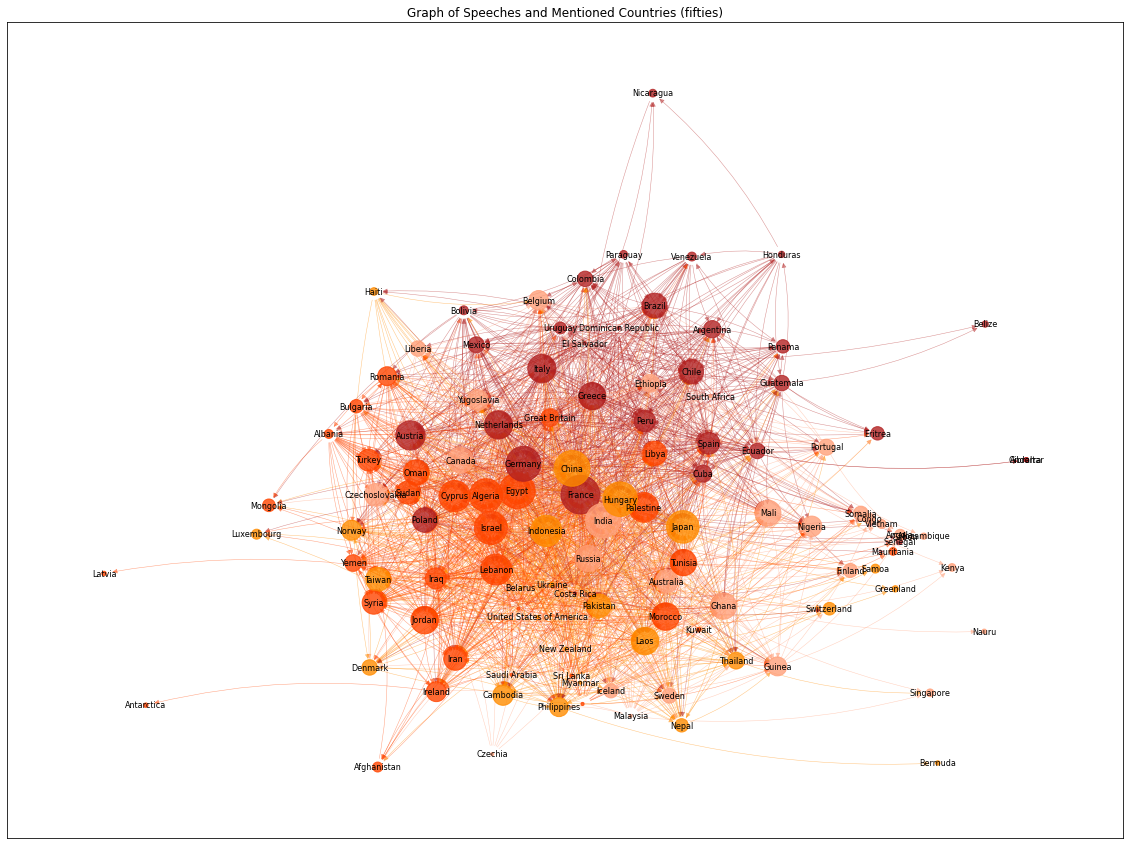

In [41]:
get_network_attributes(fifties, 'fifties')

# Create a dictionary for manually mapping community IDs to colors
community_colors = {0: 'lightsalmon', 1: 'darkorange', 2: 'firebrick', 3: 'orangered', 4: 'salmon'}

# Assuming there are community IDs 0, 1, and 2 in partition_fifties, you can remove any other community IDs
community_colors_fifties = {k: community_colors[k] for k in community_colors if k in set(partition_fifties.values())}

visualize_network(fifties, 'fifties', partition_fifties, community_colors)

Number of nodes: 183
Number of edges: 6374
Top 3 nodes with highest in-degree:
AFG In-degree: 158
NAM In-degree: 158
IRN In-degree: 157
Top 3 nodes with highest out-degree:
CUB Out-degree: 68
NIC Out-degree: 64
ZWE Out-degree: 64
Modularity using Louvain: 0.10034896069697101
Number of communities: 5
Number of nodes that satisfy the Friendship Paradox: 134
Percentage of nodes that satisfy the Friendship Paradox: 73.22%


/var/folders/18/cqtrlwhx0_s2j15jxmn6c80w0000gn/T/ipykernel_56014/2612126140.py:36: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  nx.draw_networkx_edges(graph, pos=layout, edge_color=edge_colors, width=0.5, alpha=0.5, connectionstyle="arc3,rad=0.1")


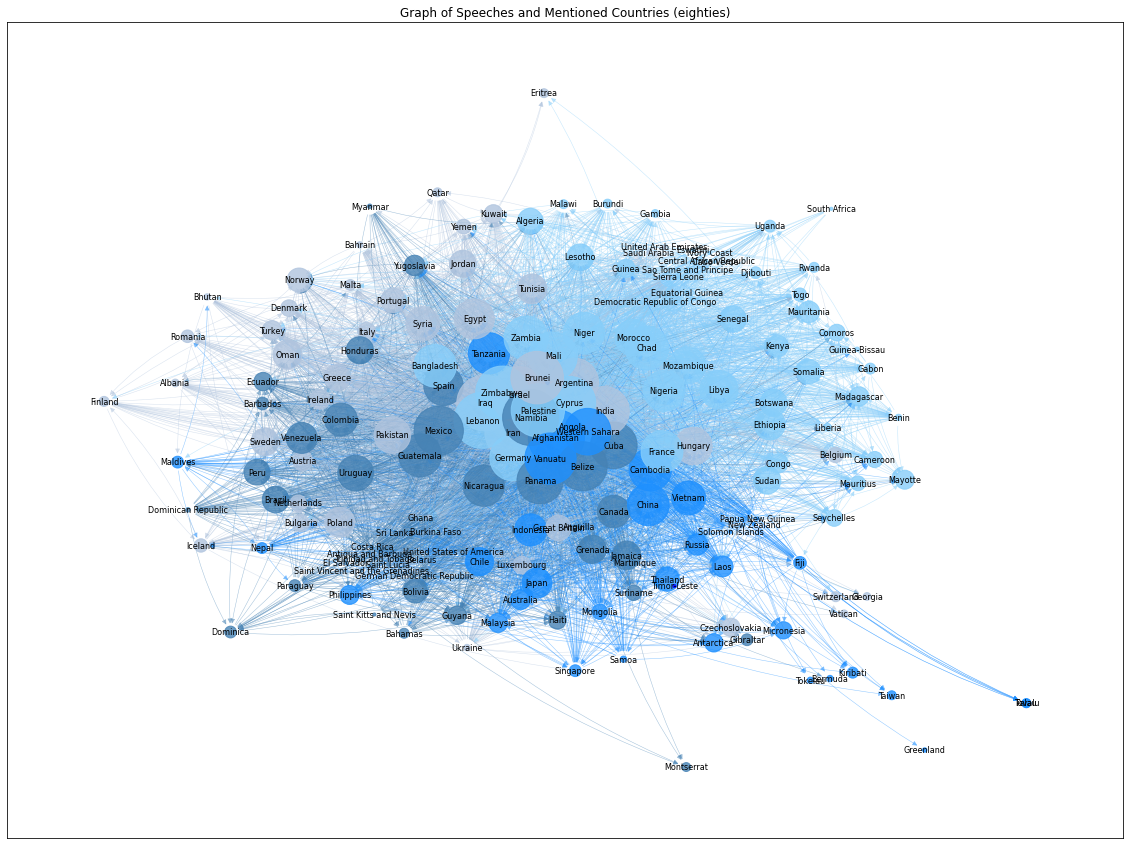

In [45]:
get_network_attributes(eighties, 'eighties')

# Create a dictionary for manually mapping community IDs to colors
community_colors_eighties = {0: 'steelblue', 1: 'lightskyblue', 2: 'dodgerblue', 3: 'blue', 4: 'lightsteelblue'} 

# Assuming there are community IDs 0, 1, and 2 in partition_eighties, you can remove any other community IDs
community_colors_eighties = {k: community_colors_eighties[k] for k in community_colors_eighties if k in set(partition_eighties.values())}

visualize_network(eighties, 'eighties', partition_eighties, community_colors_eighties)

Number of nodes: 214
Number of edges: 5416
Top 3 nodes with highest in-degree:
SYR In-degree: 168
ISR In-degree: 164
MLI In-degree: 161
Top 3 nodes with highest out-degree:
USA Out-degree: 56
ISR Out-degree: 52
BRA Out-degree: 52
Modularity using Louvain: 0.17348528321903045
Number of communities: 4
Number of nodes that satisfy the Friendship Paradox: 174
Percentage of nodes that satisfy the Friendship Paradox: 81.31%


/var/folders/18/cqtrlwhx0_s2j15jxmn6c80w0000gn/T/ipykernel_56014/2612126140.py:36: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  nx.draw_networkx_edges(graph, pos=layout, edge_color=edge_colors, width=0.5, alpha=0.5, connectionstyle="arc3,rad=0.1")


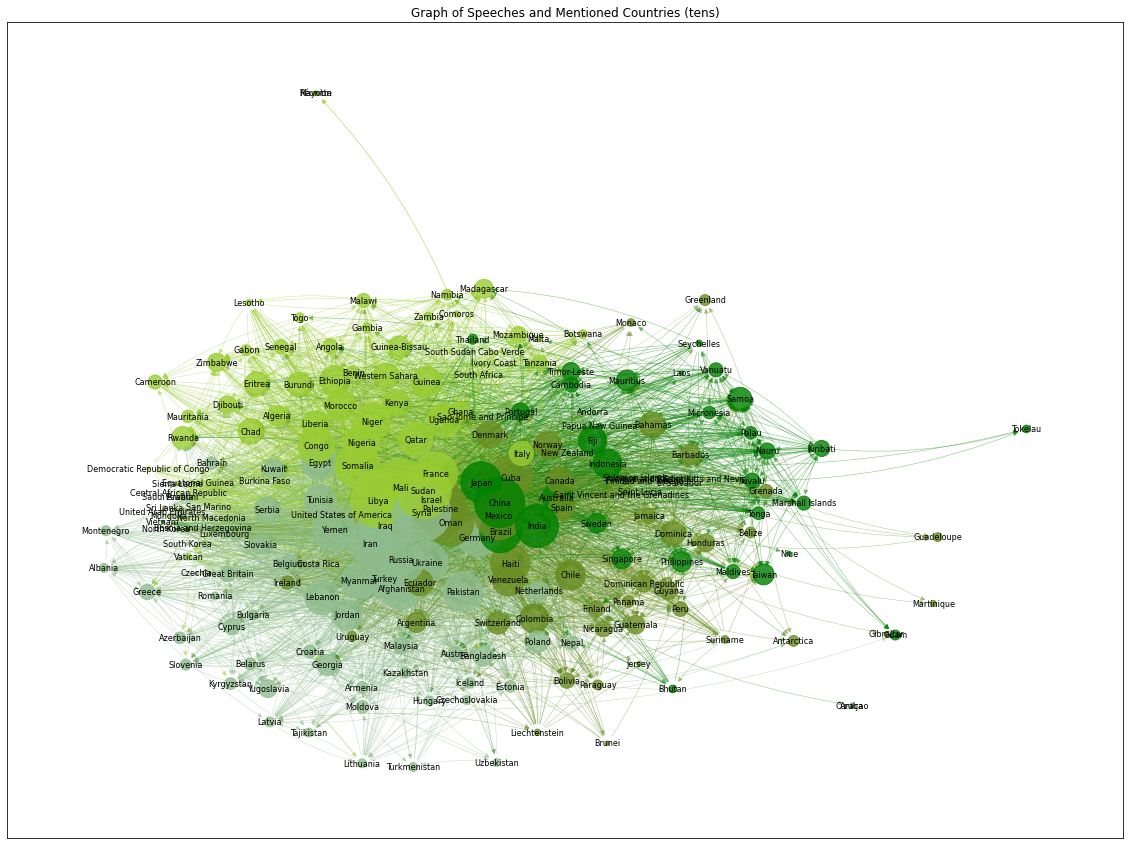

In [52]:
get_network_attributes(tens, 'tens')

community_colors_tens = {0: 'green', 1: 'darkseagreen', 2: 'yellowgreen', 3: 'olivedrab'}
# Assuming there are community IDs 0, 1, and 2 in partition_tens, you can remove any other community IDs
community_colors_tens = {k: community_colors_tens[k] for k in community_colors_tens if k in set(partition_tens.values())}

visualize_network(tens, 'tens', partition_tens, community_colors_tens)

# Word frequency over time

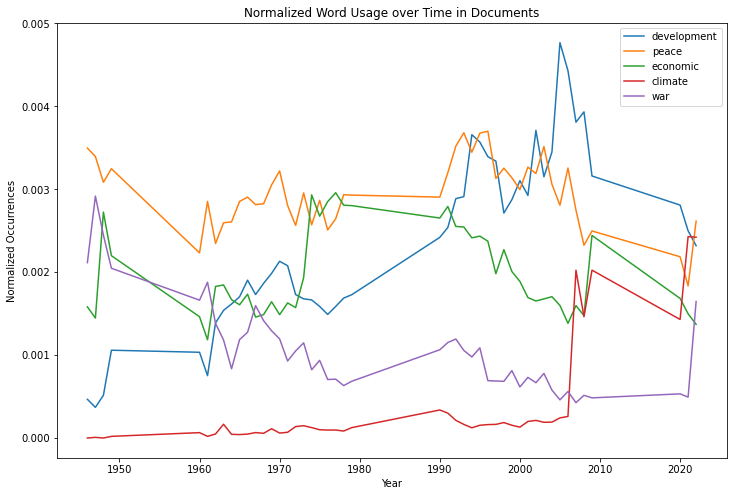

In [54]:
# Set the root folder
root_folder = 'TXT'

# Specify words of interest
words_of_interest = ['development', 'peace', 'economic', 'climate', 'war']  # Add any other words you want to track

# Initialize dictionaries to store word counts and total words over time
word_counts = {word: [] for word in words_of_interest}
total_words_over_time = []

# Loop through subfolders
for folder_name in os.listdir(root_folder):
    folder_path = os.path.join(root_folder, folder_name)

    if os.path.isdir(folder_path):
        # Initialize dictionary to store word counts for the current folder
        folder_word_counts = {word: 0 for word in words_of_interest}

        # Initialize variable to store total words in the current folder
        total_words = 0

        # Loop through files in the current folder
        for file_name in os.listdir(folder_path):
            if file_name.endswith('.txt'):
                # Read the text content of the file
                with open(os.path.join(folder_path, file_name), 'r', encoding='utf-8') as file:
                    text = file.read().lower()  # Convert to lowercase for case-insensitive matching

                    # Tokenize the text into words
                    tokens = nltk.word_tokenize(text)

                    # Count occurrences of words of interest in the document
                    for word in words_of_interest:
                        folder_word_counts[word] += tokens.count(word)

                    # Update total words in the document
                    total_words += len(tokens)

        # Append normalized word counts by total words to the overall counts
        for word in words_of_interest:
            word_counts[word].append(folder_word_counts[word] / total_words if total_words > 0 else 0)

        # Append total words to the list
        total_words_over_time.append(total_words)

# Get years (extracted from folder names)
years = [re.sub(r'\D', '', folder_name.split('-')[-1]) for folder_name in os.listdir(root_folder) if os.path.isdir(os.path.join(root_folder, folder_name))]

# Convert years to integers
years = [int(year) if year.isdigit() else 0 for year in years]

# Sort years and corresponding word counts
sorted_data = sorted(zip(years, *[word_counts[word] for word in words_of_interest]))

# Unpack sorted data
sorted_years, *sorted_word_counts = zip(*sorted_data)

# Visualize the data
plt.figure(figsize=(12, 8))
for i, word in enumerate(words_of_interest):
    plt.plot(sorted_years, sorted_word_counts[i], label=word)

plt.xlabel('Year')
plt.ylabel('Normalized Occurrences')
plt.title('Normalized Word Usage over Time in Documents')
plt.legend()
plt.show()

# Sentiment over time

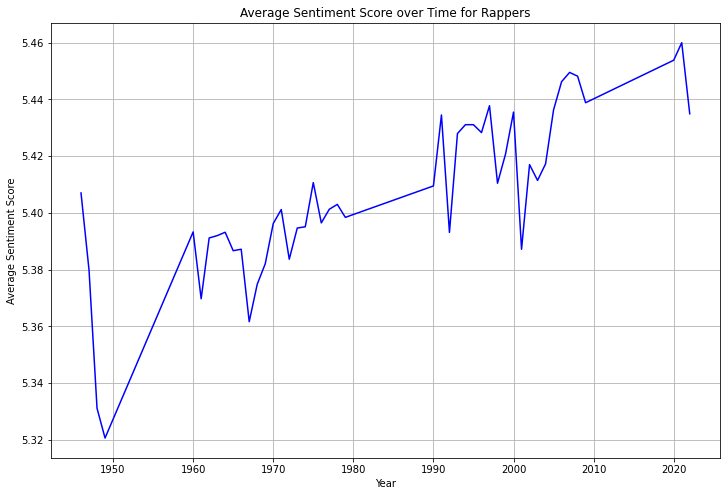

In [55]:
# Load LabMT wordlist
labmt_wordlist = pd.read_csv('Data_Set_S1.txt', sep='\t', skiprows=[0, 1])

# Create a dictionary mapping words to their happiness scores
word_to_happiness = dict(zip(labmt_wordlist['word'], labmt_wordlist['happiness_average']))

# Create function to calculate sentiment
def calculate_sentiment(tokens):
    total_happiness = 0
    num_tokens = 0

    for token in tokens:
        token = token.lower()  # Convert to lowercase
        if token in word_to_happiness:
            total_happiness += word_to_happiness[token]
            num_tokens += 1

    if num_tokens > 0:
        average_happiness = total_happiness / num_tokens
        return average_happiness
    else:
        return None  # Cases where no valid tokens were found in the LabMT list

# Set the root folder
root_folder = 'TXT'

# List to store sentiment scores for all years
all_years_sentiments = []

# Loop through subfolders (years)
for folder_name in os.listdir(root_folder):
    folder_path = os.path.join(root_folder, folder_name)

    if os.path.isdir(folder_path):
        # Extract the last four digits from the folder name
        year_str = folder_name.split('-')[-1][-4:]
        if year_str.isdigit():
            year = int(year_str)
        else:
            continue  # Skip folders without a four-digit year
        
        # Initialize variables to store sentiment scores for the current folder (year)
        year_sentiments = []
        
        # Loop through files in the current folder
        for file_name in os.listdir(folder_path):
            if file_name.endswith('.txt'):
                # Read the text content of the file
                with open(os.path.join(folder_path, file_name), 'r') as file:
                    text = file.read()
                    tokens = nltk.word_tokenize(text)
                    clean_tokens = [word.lower() for word in tokens if word.isalnum()]
                    sentiment_score = calculate_sentiment(clean_tokens)
                    year_sentiments.append(sentiment_score)  # Append sentiment score

        # Calculate average sentiment for the year and append to the overall list
        average_sentiment = sum(sent for sent in year_sentiments if sent is not None) / len(year_sentiments)
        all_years_sentiments.append((year, average_sentiment))

# Sort years and corresponding sentiment scores
sorted_sentiments = sorted(all_years_sentiments, key=lambda x: x[0])

# Unpack sorted data
sorted_years, sorted_avg_sentiments = zip(*sorted_sentiments)

# Visualize the data
plt.figure(figsize=(12, 8))
plt.plot(sorted_years, sorted_avg_sentiments, linestyle='-', color='b')
plt.xlabel('Year')
plt.ylabel('Average Sentiment Score')
plt.title('Average Sentiment Score over Time for Rappers')
plt.grid(True)
plt.show()

In [ ]:
# Creating 1950s corpus

file_path = '/Users/alliehale/Desktop/social graphs and interactions/1950s'
def read_text_file(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        return file.read()

def aggregate_texts(root_folder):
    corpus = ""
    for subdir, dirs, files in os.walk(root_folder):
        for filename in files:
            if filename.endswith('.txt'):
                file_path = os.path.join(subdir, filename)
                corpus += read_text_file(file_path) + "\n"
    return corpus

# Adjust the path according to your operating system and username
desktop_path = os.path.join(os.path.expanduser('~'), 'Desktop')
folder_path = os.path.join(desktop_path, 'social graphs and interactions', '1950s')

corpus = aggregate_texts(folder_path)

# If you want to save the corpus into a new file:
with open('1950s_corpus.txt', 'w', encoding='utf-8') as f:
    f.write(corpus)

print("Aggregation complete!")

In [ ]:
# Creating 1980s corpus

file_path = '/Users/alliehale/Desktop/social graphs and interactions/1980s'
def read_text_file(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        return file.read()

def aggregate_texts(root_folder):
    corpus = ""
    for subdir, dirs, files in os.walk(root_folder):
        for filename in files:
            if filename.endswith('.txt'):
                file_path = os.path.join(subdir, filename)
                corpus += read_text_file(file_path) + "\n"
    return corpus

# Adjust the path according to your operating system and username
desktop_path = os.path.join(os.path.expanduser('~'), 'Desktop')
folder_path = os.path.join(desktop_path, 'social graphs and interactions', '1980s')

corpus = aggregate_texts(folder_path)

# If you want to save the corpus into a new file:
with open('1980s_corpus.txt', 'w', encoding='utf-8') as f:
    f.write(corpus)

print("Aggregation complete!")

In [ ]:
# Creating 2010s corpus

file_path = '/Users/alliehale/Desktop/social graphs and interactions/2010s'
def read_text_file(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        return file.read()

def aggregate_texts(root_folder):
    corpus = ""
    for subdir, dirs, files in os.walk(root_folder):
        for filename in files:
            if filename.endswith('.txt'):
                file_path = os.path.join(subdir, filename)
                corpus += read_text_file(file_path) + "\n"
    return corpus

# Adjust the path according to your operating system and username
desktop_path = os.path.join(os.path.expanduser('~'), 'Desktop')
folder_path = os.path.join(desktop_path, 'social graphs and interactions', '2010s')

corpus = aggregate_texts(folder_path)

# If you want to save the corpus into a new file:
with open('2010s_corpus.txt', 'w', encoding='utf-8') as f:
    f.write(corpus)

print("Aggregation complete!")

In [ ]:
# Removing stopwords from each corpus

nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

# Download necessary NLTK resources
nltk.download('punkt')
nltk.download('stopwords')

# Create function that removes stopwords from corpus
def remove_stopwords(text):
    """
    Removes stopwords from a given text.

    Parameters:
    text (str): The text from which to remove stopwords.

    Returns:
    str: The text with stopwords removed.
    """
    # Setting up English stopwords
    stop_words = set(stopwords.words('english'))

    # Tokenize the text
    words = word_tokenize(text)

    # Filter out the stopwords
    filtered_words = [word for word in words if word.lower() not in stop_words]

    # Reassemble the cleaned text
    cleaned_text = ' '.join(filtered_words)

    return cleaned_text

In [ ]:
file_path = '/Users/alliehale/Desktop/social graphs and interactions/1950s_corpus.txt'

with open(file_path, 'r', encoding='utf-8') as file:
    fifties_corpus = file.read()
    
file_path = '/Users/alliehale/Desktop/social graphs and interactions/1980s_corpus.txt'

with open(file_path, 'r', encoding='utf-8') as file:
    eighties_corpus = file.read()
    
file_path = '/Users/alliehale/Desktop/social graphs and interactions/2010s_corpus.txt'

with open(file_path, 'r', encoding='utf-8') as file:
    twentytens_corpus = file.read()

In [ ]:
# Perform function for each corpus
fifties_corpus_clean = remove_stopwords(fifties_corpus)
eighties_corpus_clean = remove_stopwords(eighties_corpus)
twentytens_corpus_clean = remove_stopwords(twentytens_corpus)

In [ ]:
# Create a function to lemmatize

def lemmatize_corpus(corpus):
    """
    Lemmatizes the entire corpus.

    Parameters:
    corpus (str): The text to lemmatize.

    Returns:
    str: The lemmatized text.
    """
    lemmatizer = WordNetLemmatizer()
    tokens = word_tokenize(corpus)
    lemmatized_output = ' '.join([lemmatizer.lemmatize(w) for w in tokens])

    return lemmatized_output

In [ ]:
fifties_corpus_cleaner = lemmatize_corpus(fifties_corpus_clean)
eighties_corpus_cleaner = lemmatize_corpus(eighties_corpus_clean)
twentytens_corpus_cleaner = lemmatize_corpus(twentytens_corpus_clean)

In [ ]:
def clean_text(text):
    """
    Cleans the text by removing all punctuation, numbers, 
    and converting to lowercase.

    Parameters:
    text (str): The text to be cleaned.

    Returns:
    str: The cleaned text.
    """
    # Remove punctuation
    text_no_punctuation = text.translate(str.maketrans('', '', string.punctuation))

    # Remove numbers
    text_no_numbers = re.sub(r'\d+', '', text_no_punctuation)

    # Convert to lowercase
    cleaned_text = text_no_numbers.lower()

    return cleaned_text

# Example usage
fifties_most_clean = clean_text(fifties_corpus_cleaner)
eighties_most_clean = clean_text(eighties_corpus_cleaner)
twentytens_most_clean = clean_text(twentytens_corpus_cleaner)

In [ ]:
desktop_path = os.path.join(os.path.expanduser('~'), 'Desktop')
folder_path = os.path.join(desktop_path, 'social graphs and interactions')

In [ ]:
# Paths for the cleaned corpus files
fifties_corpus_cleaned_path = os.path.join(folder_path, '1950s_corpus_most_clean.txt')
eighties_corpus_cleaned_path = os.path.join(folder_path, '1980s_corpus_most_clean.txt')
twentytens_corpus_cleaned_path = os.path.join(folder_path, '2010s_corpus_most_clean.txt')

# Write the cleaned and lemmatized corpuses to new files
with open(fifties_corpus_cleaned_path, 'w', encoding='utf-8') as f:
    f.write(fifties_most_clean)

with open(eighties_corpus_cleaned_path, 'w', encoding='utf-8') as f:
    f.write(eighties_most_clean)

with open(twentytens_corpus_cleaned_path, 'w', encoding='utf-8') as f:
    f.write(twentytens_most_clean)